In [1]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Embedding, Activation, RepeatVector, Bidirectional, Concatenate, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import one_hot
from keras.utils import np_utils
from sklearn.preprocessing import label_binarize

Using TensorFlow backend.


In [2]:
!wget https://www.dropbox.com/s/j8v4lzef5kzr0se/DataSet.zip?dl=0
!unzip DataSet.zip?dl=0

--2019-06-03 23:23:41--  https://www.dropbox.com/s/j8v4lzef5kzr0se/DataSet.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/j8v4lzef5kzr0se/DataSet.zip [following]
--2019-06-03 23:23:41--  https://www.dropbox.com/s/raw/j8v4lzef5kzr0se/DataSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6d88a085d28f18e039ba6d855b.dl.dropboxusercontent.com/cd/0/inline/AiI7lPPxTvdkaeFi2eQU0BF6dSlWFyIsK0N-tm6DahL7JJ_H_lObvCzw6-_F02W1ABDqkpV4UwnlrpEs54QVdk4LFPh3ucOf-SDm6pcdPx5bSA/file# [following]
--2019-06-03 23:23:41--  https://uc6d88a085d28f18e039ba6d855b.dl.dropboxusercontent.com/cd/0/inline/AiI7lPPxTvdkaeFi2eQU0BF6dSlWFyIsK0N-tm6DahL7JJ_H_lObvCzw6-_F02W1ABDqkpV4UwnlrpEs54QVdk4LFPh3ucOf-SDm6pcdPx5bSA/file
Resolving uc6d88a

In [0]:
#Datos desde DRIVE
train = pd.read_csv('/content/DataSet/train.csv')
test = pd.read_csv('/content/DataSet/test.csv')

In [9]:
x_train = train['sentence'].as_matrix()
y_train = train['relation'].as_matrix()

x_test = test['sentence'].as_matrix()
y_test = test['relation'].as_matrix()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
x_train2c=[]
x_train2t=[]
#y_train2=[]

for i in range(13340):
  if y_train[i] == 'causes':
    x_train2c.append(x_train[i])
    #y_train2.append(0)
  elif y_train[i] == 'treats':
    x_train2t.append(x_train[i])
    #y_train2.append(1)  
    
x_test2c=[]
x_test2t=[]

for i in range(4566):
  if y_test[i] == 'causes':
    x_test2c.append(x_test[i])
    #y_test2.append(y_test[i])
  elif y_test[i] == 'treats':
    x_test2t.append(x_test[i])
    #y_test2.append(y_test[i]) 

In [0]:
causesTrain=pd.Series(x_train2c).unique()
treatsTrain=pd.Series(x_train2t).unique()
causesTest=pd.Series(x_test2c).unique()
treatsTest=pd.Series(x_test2t).unique()


In [0]:
X_train=[]
X_test=[]
y_train=[]
y_test=[]
for i in causesTrain:
  X_train.append(i)
  y_train.append(0)
for i in treatsTrain:
  X_train.append(i)
  y_train.append(1)
for i in causesTest:
  X_test.append(i)
  y_test.append(0)
for i in treatsTest:
  X_test.append(i)
  y_test.append(1)
  
  

In [0]:
df=pd.DataFrame()
df['Frase']=X_train
df['Label']=y_train

In [0]:
dftest=pd.DataFrame()
dftest['Frase']=X_test
dftest['Label']=y_test

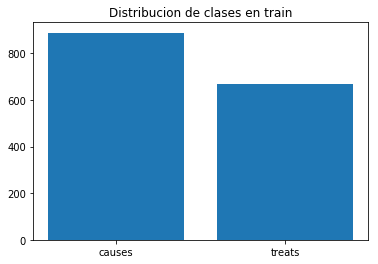

In [15]:
plt.bar(['causes','treats'],df['Label'].value_counts())
plt.title('Distribucion de clases en train');

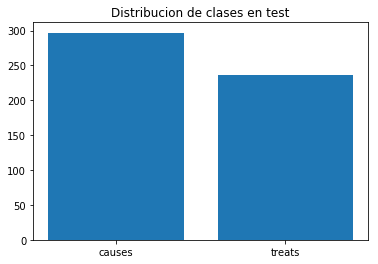

In [16]:
plt.bar(['causes','treats'],dftest['Label'].value_counts())
plt.title('Distribucion de clases en test');

* Existe desbalance de clase, lo tendremos en cuenta en los parametros del modelo.

* El set de datos estaba particionado completamente, aplicamos un muestreo para 'desordenar' el dataframe.

In [17]:
dftest=dftest.sample(frac=1).reset_index(drop=True)
df=df.sample(frac=1).reset_index(drop=True)
df.head()

,Frase,Label
0,• Hypoglycemia and respiratory depression were...,1
1,"Symptoms of UNSTABLE ANGINA or infarction, isc...",0
2,• FIBROMYALGIA characterized by widespread PAI...,0
3,Other medications which may be effective inclu...,1
4,"By contrast, CHRONIC GRANULOCYTIC LEUKEMIA CEL...",0


In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
aW=[]
# Removing Stop Words
import re 
processed_article = df['Frase'].values

for j in range(df['Frase'].values.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu','t','b','c','g','e','p','m','d','j','i']]

    aW.append(all_words[0])

In [0]:
aWt=[]
# Removing Stop Words
import re 
processed_article = dftest['Frase'].values

for j in range(dftest['Frase'].values.shape[0]):  
    processed_article[j] = re.sub("'S", ' ', processed_article[j])  
    processed_article[j] = re.sub('[^a-zA-Z]', ' ', processed_article[j])    
    processed_article[j] = re.sub(r'\s+', ' ', processed_article[j])
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(processed_article[j])
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    for i in range(len(all_words)):
      
        all_words[i] = [w.lower() for w in all_words[i] if w not in stopwords.words('english')]
        all_words[i] = [w for w in all_words[i] if w not in ['s','l','a','the','of','v','tu','t','b','c','g','e','p','m','d','j','i']]

    aWt.append(all_words[0])

## En este notebook usaremos un tokenizador con 1000 palabras
* Como son menos palabras el padding se hace con 10 

In [0]:
max_fatures = 1000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aW)
X = tokenizer.texts_to_sequences(aW)
Xt = tokenizer.texts_to_sequences(aWt)

In [23]:
from keras.preprocessing.sequence import pad_sequences
Xpad=pad_sequences(X,padding='post',maxlen=10)
voc=Xpad[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpad[0].size))

El tamaño maximo de la secuencia es 10


In [24]:
Xpadt=pad_sequences(Xt,padding='post',maxlen=10)
voct=Xpadt[0].size
print('El tamaño maximo de la secuencia es '+ str(Xpadt[0].size))

El tamaño maximo de la secuencia es 10


In [25]:
Xpad[1000]

array([165, 534, 777, 465,  47,   0,   0,   0,   0,   0], dtype=int32)

In [0]:
from keras.layers import Dense,LSTM,Dropout,GRU,SimpleRNN,Embedding,Dropout
from keras.models import Sequential

In [27]:
model =Sequential()
model.add(Embedding(1000,128,input_length=voc,mask_zero=True))
model.compile('adam','mse')
out=model.predict(Xpad) # x train
out.shape

Instructions for updating:
Colocations handled automatically by placer.


(1558, 10, 128)

In [28]:
opt = Adam(lr=0.0001, decay=1e-5)
model1 =Sequential()
model1.add(Embedding(1000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='relu'))
model1.compile(optimizer=opt,loss='mse',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.75, 1:1.0})

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 4s 2ms/step - loss: 0.3845 - acc: 0.5700 - val_loss: 0.3308 - val_acc: 0.5572
Epoch 2/25
1558/1558 [==============================] - 3s 2ms/step - loss: 0.2335 - acc: 0.6027 - val_loss: 0.2397 - val_acc: 0.6116
Epoch 3/25
1558/1558 [==============================] - 3s 2ms/step - loss: 0.1719 - acc: 0.7182 - val_loss: 0.2018 - val_acc: 0.6979
Epoch 4/25
1558/1558 [==============================] - 3s 2ms/step - loss: 0.1381 - acc: 0.7843 - val_loss: 0.1797 - val_acc: 0.7467
Epoch 5/25
1558/1558 [==============================] - 3s 2ms/step - loss: 0.1193 - acc: 0.8177 - val_loss: 0.1698 - val_acc: 0.7561
Epoch 6/25
1558/1558 [==============================] - 3s 2ms/step - loss: 0.1059 - acc: 0.8389 - val_loss: 0.1701 - va

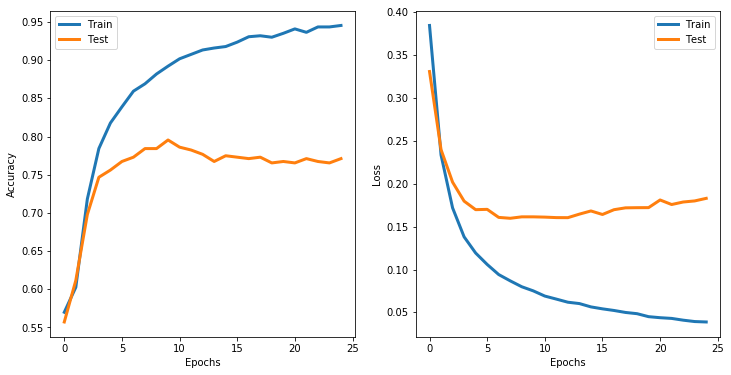

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss');

In [32]:
from sklearn.metrics import classification_report
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.80      0.80      0.80       297
 Tratamiento       0.75      0.75      0.75       236

   micro avg       0.78      0.78      0.78       533
   macro avg       0.78      0.78      0.78       533
weighted avg       0.78      0.78      0.78       533



In [34]:
opt = Adam(lr=0.0001, decay=1e-5)
model1 =Sequential()
model1.add(Embedding(2000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=196, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='sigmoid'))
model1.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=20, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.75, 1:1.0})

Train on 1558 samples, validate on 533 samples
Epoch 1/20
1558/1558 [==============================] - 4s 3ms/step - loss: 0.5936 - acc: 0.5610 - val_loss: 0.6902 - val_acc: 0.6792
Epoch 2/20
1558/1558 [==============================] - 3s 2ms/step - loss: 0.5880 - acc: 0.7458 - val_loss: 0.6803 - val_acc: 0.7786
Epoch 3/20
1558/1558 [==============================] - 3s 2ms/step - loss: 0.5456 - acc: 0.7831 - val_loss: 0.5635 - val_acc: 0.7880
Epoch 4/20
1558/1558 [==============================] - 3s 2ms/step - loss: 0.3999 - acc: 0.8261 - val_loss: 0.5177 - val_acc: 0.7861
Epoch 5/20
1558/1558 [==============================] - 3s 2ms/step - loss: 0.3429 - acc: 0.8466 - val_loss: 0.5138 - val_acc: 0.7917
Epoch 6/20
1558/1558 [==============================] - 3s 2ms/step - loss: 0.3086 - acc: 0.8646 - val_loss: 0.5169 - val_acc: 0.7917
Epoch 7/20
1558/1558 [==============================] - 3s 2ms/step - loss: 0.2802 - acc: 0.8723 - val_loss: 0.5263 - val_acc: 0.7824
Epoch 8/20
1558

Text(0,0.5,'Loss')

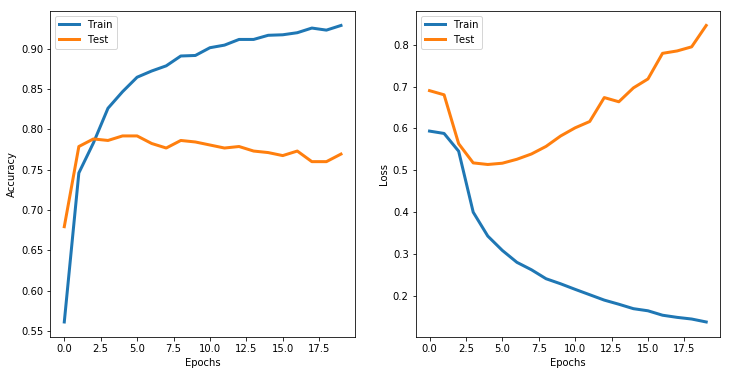

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h1.history['acc'],label='Train',linewidth=3)
plt.plot(h1.history['val_acc'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(h1.history['loss'],label='Train',linewidth=3)
plt.plot(h1.history['val_loss'],label='Test',linewidth=3)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [36]:
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.80      0.77      0.79       297
 Tratamiento       0.73      0.76      0.75       236

   micro avg       0.77      0.77      0.77       533
   macro avg       0.77      0.77      0.77       533
weighted avg       0.77      0.77      0.77       533



* Debido al comportamiento del loss aplicaremos regularizacion esperando que mejore el rendimiento del modelo

In [37]:
from keras import regularizers
opt = Adam(lr=0.0001, decay=1e-5)
model1 =Sequential()
model1.add(Embedding(1000,128,input_length=voc,mask_zero=True))
model1.add(LSTM(units=150, input_shape=out.shape,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(units=1,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))
model1.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
h1=model1.fit(Xpad,df['Label'].values,epochs=25, batch_size=32,validation_data=(Xpadt,dftest['Label'].values),class_weight={0:0.75, 1:1.0})

Train on 1558 samples, validate on 533 samples
Epoch 1/25
1558/1558 [==============================] - 4s 3ms/step - loss: 0.6138 - acc: 0.5494 - val_loss: 0.7101 - val_acc: 0.6210
Epoch 2/25
1558/1558 [==============================] - 2s 1ms/step - loss: 0.6074 - acc: 0.7015 - val_loss: 0.7007 - val_acc: 0.7355
Epoch 3/25
1558/1558 [==============================] - 2s 1ms/step - loss: 0.5840 - acc: 0.8004 - val_loss: 0.6473 - val_acc: 0.7617
Epoch 4/25
1558/1558 [==============================] - 2s 1ms/step - loss: 0.4588 - acc: 0.8267 - val_loss: 0.5585 - val_acc: 0.7674
Epoch 5/25
1558/1558 [==============================] - 2s 1ms/step - loss: 0.3720 - acc: 0.8363 - val_loss: 0.5466 - val_acc: 0.7880
Epoch 6/25
1558/1558 [==============================] - 2s 1ms/step - loss: 0.3340 - acc: 0.8582 - val_loss: 0.5329 - val_acc: 0.7955
Epoch 7/25
1558/1558 [==============================] - 2s 1ms/step - loss: 0.3083 - acc: 0.8736 - val_loss: 0.5419 - val_acc: 0.7974
Epoch 8/25
1558

In [38]:
y_pred=model1.predict_classes(Xpadt)
target_names = ['Causa','Tratamiento']
print(classification_report(dftest['Label'].values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Causa       0.80      0.79      0.80       297
 Tratamiento       0.74      0.76      0.75       236

   micro avg       0.77      0.77      0.77       533
   macro avg       0.77      0.77      0.77       533
weighted avg       0.78      0.77      0.78       533



## Utilizar menos palabras en el tokenizador empeora el rendimiento del modelo